## Data Reduction of MQ-SCExAO Lab Spectrograph

### 7 cores single mode fiber input, oriented in rotation for maximum seperation in cross dispersion direction

#### Setup Notes

Using a ZWO ASI183MM CMOS camera as the detector


* Sensor type	CMOS
* Sensor specification	 1/3″ CMOS
* Pixel Size: 2.4µm
* Bit rate: 12bit output (12bit ADC)

The setups:

Using the inner 7 cores of a 19 core Single mode Multicore Fiber
laser cut brass aperture inserted between the ferrule and the FC/PC connector are masking the outer fiber

other end of the MCF has 3D nano printed microlenses and is couple to SCExAO

Spectrograph has an R4 grating, whihc is fed from a reimaging fiber input and collimated by a 200 mm ITL lens

cross dispersion is done by a 200 line/mm grating, some significant gamma angle

camera lens is another 200 mm TTL lens

Setup is non enclosed

### import the necessary packages

In [228]:
import matplotlib.pyplot as plt  
import pandas as pd  
import os
import numpy as np
from astropy.io import fits 

from PIL import Image


#conda install -c astropy photutils

from photutils import centroid_com, centroid_1dg, centroid_2dg

#need to install newer version of scipy from conda, need 1.2 or newer for find_peaks function

from scipy.signal import find_peaks
from scipy.signal import medfilt

#for animations
from matplotlib import animation, rc
from IPython.display import HTML

#patches
from matplotlib import patches as patches

import ccdproc
from astropy.nddata import CCDData
import astropy.units as u

import os
import glob

### Set the pixel size for your detector
The ZWO ASI183MM camera 

In [20]:
pixelsize=2.4

### Set up data store directories

In [21]:
datastore_path="c:/cloudstor/datastore/SCExAO-MCF/"
proc_dir="processed/"
run_dir="16-10-2019/"
run_dir2="18-10-2019/"

### Collect filenames

In [22]:
#bias_files=["super-k-0001bias.fit","super-k-0002bias.fit","super-k-0003bias.fit"]

bias_files=glob.glob(os.path.join(datastore_path,run_dir,"super*bias*"))

print(bias_files)

#dark_files=["gamma-dark-480.fit","gamma-dark-480-2.fit"]

dark_files=glob.glob(os.path.join(datastore_path,run_dir,"*dark-480*"))

print(dark_files)


#flat_files=[datastore_path + run_dir + "super-k-flat-10.fit"]
flat_files=[datastore_path + run_dir2 + "halogen.fit"]


print(flat_files)

science_files=[datastore_path + run_dir + "gamma_1.fit"]

print(science_files)

cal_files=glob.glob(os.path.join(datastore_path,run_dir,"*xe-300*"))

print(cal_files)


['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0001bias.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0002bias.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0003bias.fit']
['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\gamma-dark-480-2.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\gamma-dark-480.fit']
['c:/cloudstor/datastore/SCExAO-MCF/18-10-2019/halogen.fit']
['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019/gamma_1.fit']
['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-1.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-2.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300-3.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\xe-300.fit']


## I. Prepare Images

### Create Master bias

In [23]:
mb_filename=os.path.join(datastore_path,proc_dir,"masterbias.fit")

if os.path.exists(mb_filename) == False:
    mb_ccd = ccdproc.combine(bias_files,mb_filename,method="median",unit="adu")
else:
    mb_ccd = CCDData.read(mb_filename)  
    
    
#im = fits.open(mb_filename)
#mb_imarray=im[0].data

print(np.mean(mb_ccd))
print(np.min(mb_ccd))
print(np.max(mb_ccd))


712.7581199874419
420.0
1004.0


### Create Master dark and bias correct it

In [51]:
dk_filename=os.path.join(datastore_path,proc_dir,"masterdark.fit")
dark_exp = 300.0*u.second
flat_exp = 300.0*u.second
sci_exp = 480.0*u.second
cal_exp = 300.0*u.second


if os.path.exists(dk_filename) == False:
    darkcombined = ccdproc.combine(dark_files,method="median",unit="adu")
    dk_ccd = ccdproc.subtract_bias(darkcombined, mb_ccd)
    #hdulist = masterdark.to_hdu()
    dk_ccd.write(dk_filename)
else:
    dk_ccd = CCDData.read(dk_filename)

darkpixel = (np.mean(dk_ccd)).round(0)
print(darkpixel)
print(np.min(dk_ccd))
print(np.max(dk_ccd))

#[a < 0] = 0

38.0
-336.0
16428.0


### Preview the halogen flat, 300s exposure

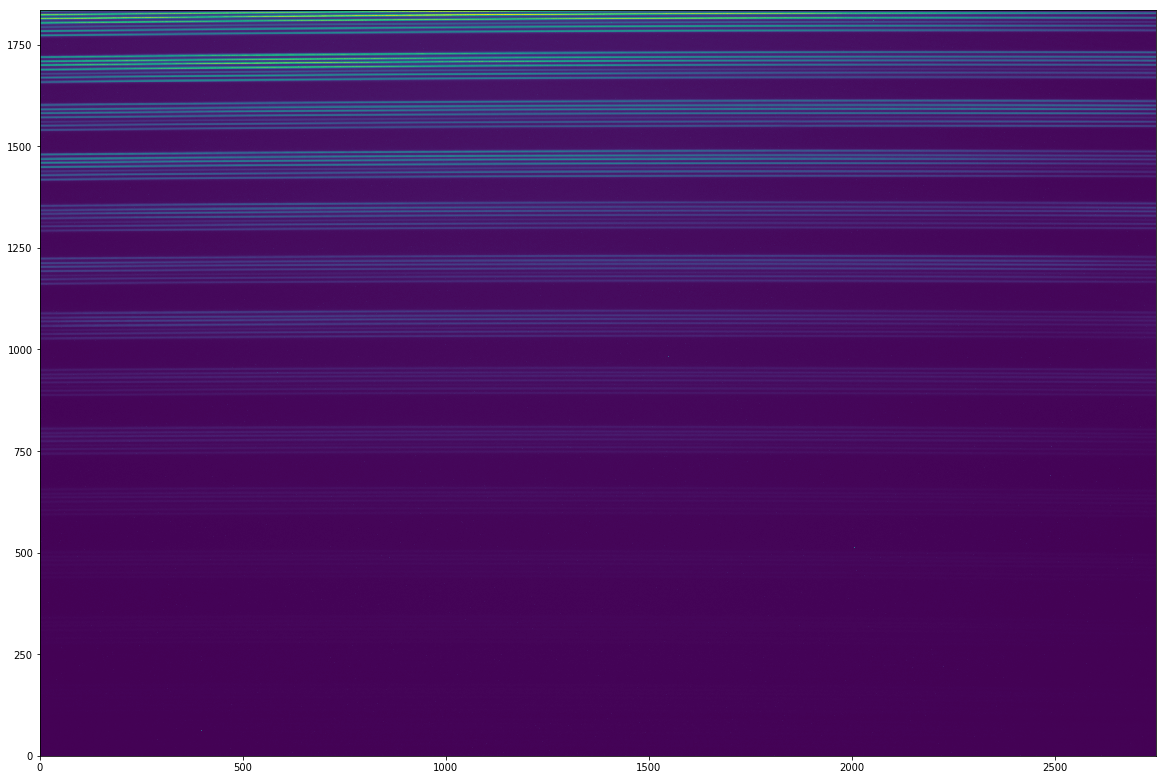

In [25]:
flat_ccd = CCDData.read(flat_files[0],unit="adu")

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(flat_ccd,origin='lower',cmap='viridis')

### Preview the science exposure

In [26]:
#im = fits.open(science_files[0])
#sci_imarray=im[0].data

sci_ccd = CCDData.read(science_files[0], unit="adu")

#Exposure is binned 2, 480 sec of Gamma gem, taken through SCExAO, 3dprinted MCF at highest observability

In [27]:
sci_ccd.shape

(1836, 2748)

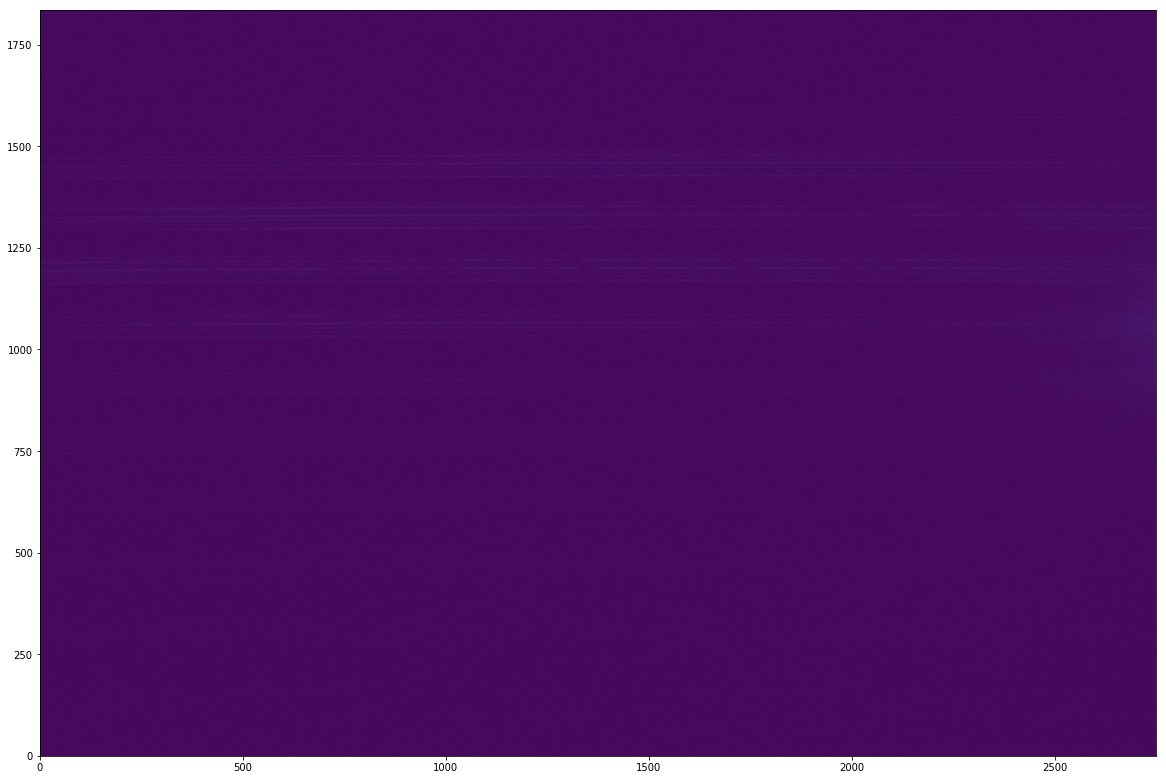

In [28]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(sci_ccd,origin='lower',cmap='viridis')

### Subtract Darks and Bias from flat exposure

Text(0.5,1,'Orders')

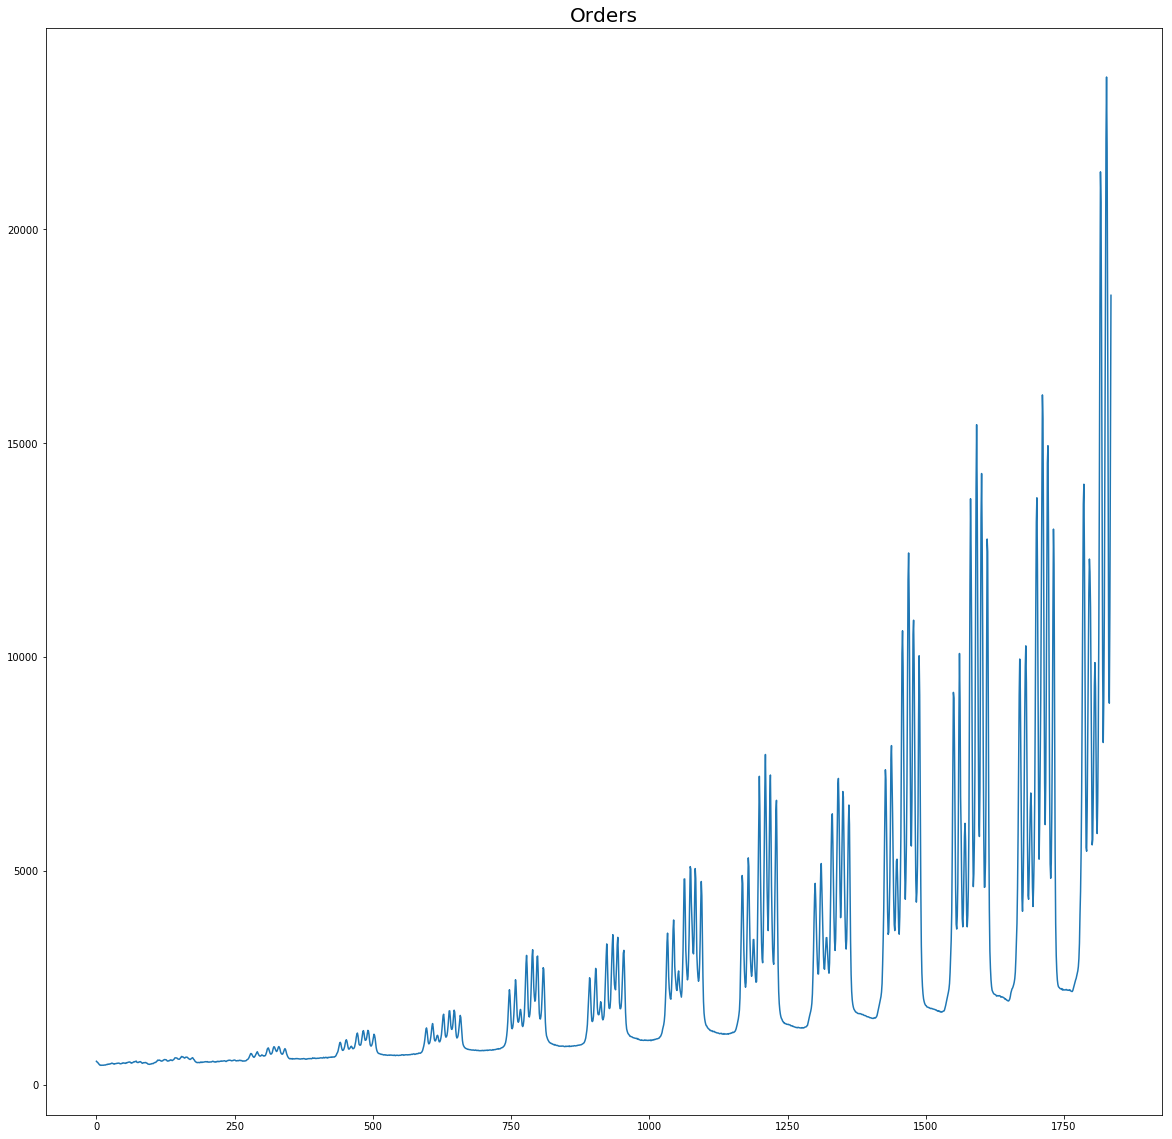

In [57]:


procflat = ccdproc.subtract_bias(flat_ccd, mb_ccd)
procflat = ccdproc.subtract_dark(procflat,dk_ccd, data_exposure = flat_exp, dark_exposure = dark_exp, scale = True)

#median filter
#procflat = ccdproc.median_filter(procflat,size=2)

#instead of median filter, do a swap of the negative values with the dark pixel median
procflat.data[procflat.data < 0] = darkpixel

plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=1))
plt.title("Orders",fontsize=20)
#plt.plot(xx,yy_sg,'k', label= "Smoothed curve")


Text(0.5,1,'Blaze trace')

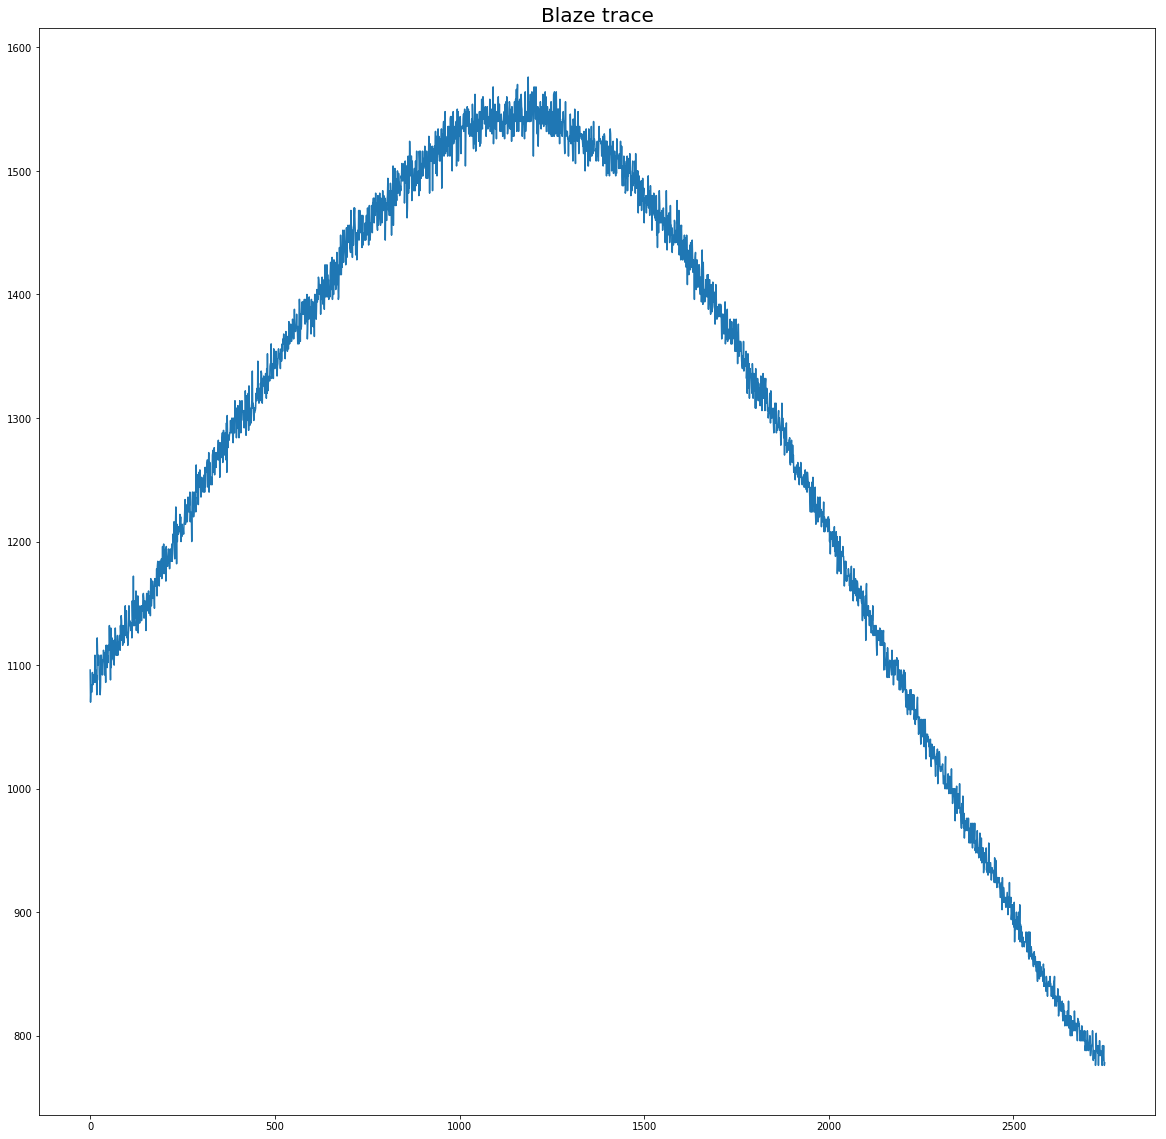

In [58]:
plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=0))
plt.title("Blaze trace",fontsize=20)

### Subtract Darks and Bias from xe exposure

In [59]:
cal_ccd = CCDData.read(cal_files[0], unit="adu")

proccal = ccdproc.subtract_bias(cal_ccd, mb_ccd)


proccal = ccdproc.subtract_dark(proccal,dk_ccd, data_exposure = cal_exp, dark_exposure = dark_exp, scale = True)
#, scale = True)v

proccal.data[proccal.data < 0] = darkpixel

#proccal = ccdproc.median_filter(proccal,size=2)


print(proccal)

[[24. 20. 38. ... 38. 38. 38.]
 [ 4. 38. 24. ... 24. 38. 20.]
 [32. 38. 38. ... 38. 38. 24.]
 ...
 [20. 38. 38. ...  0. 40. 38.]
 [24. 38. 38. ... 38. 38. 38.]
 [38. 38. 38. ... 28.  4. 32.]]


### Subtract Darks and Bias from science exposure

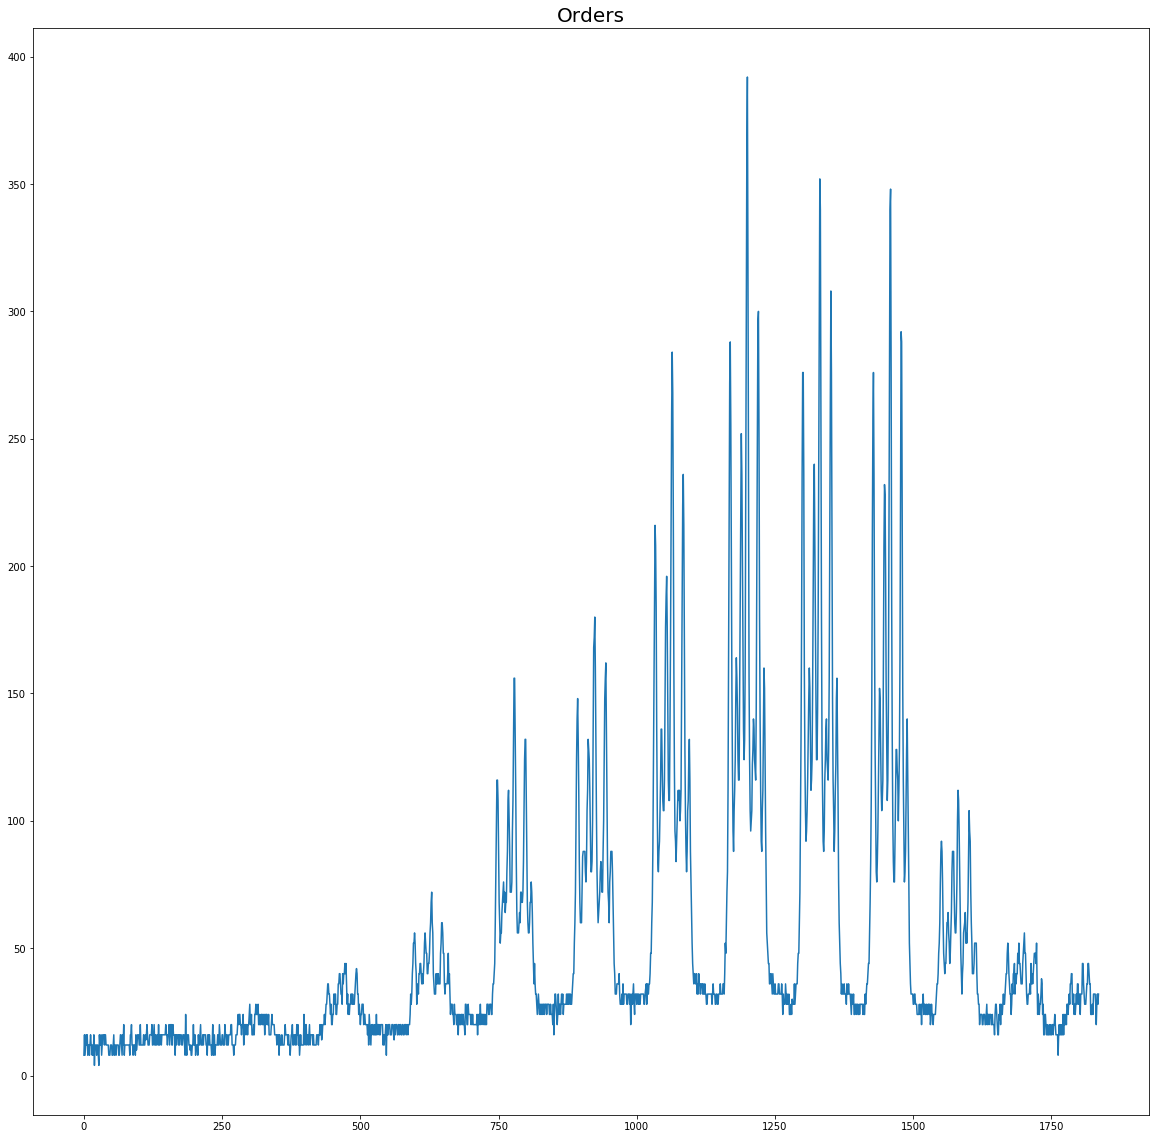

In [61]:
procsci = ccdproc.subtract_bias(sci_ccd, mb_ccd)


procsci = ccdproc.subtract_dark(procsci,dk_ccd, data_exposure = cal_exp, dark_exposure = dark_exp, scale = True)

#print(procsci)

plt.figure(figsize=(20, 20))
plt.plot(np.median(procsci,axis=1))
plt.title("Orders",fontsize=20)

#procsci[procsci]

procsci.data[procsci.data < 0] = darkpixel

#procsci = ccdproc.median_filter(procsci,size=2)



### Plot the processed frames

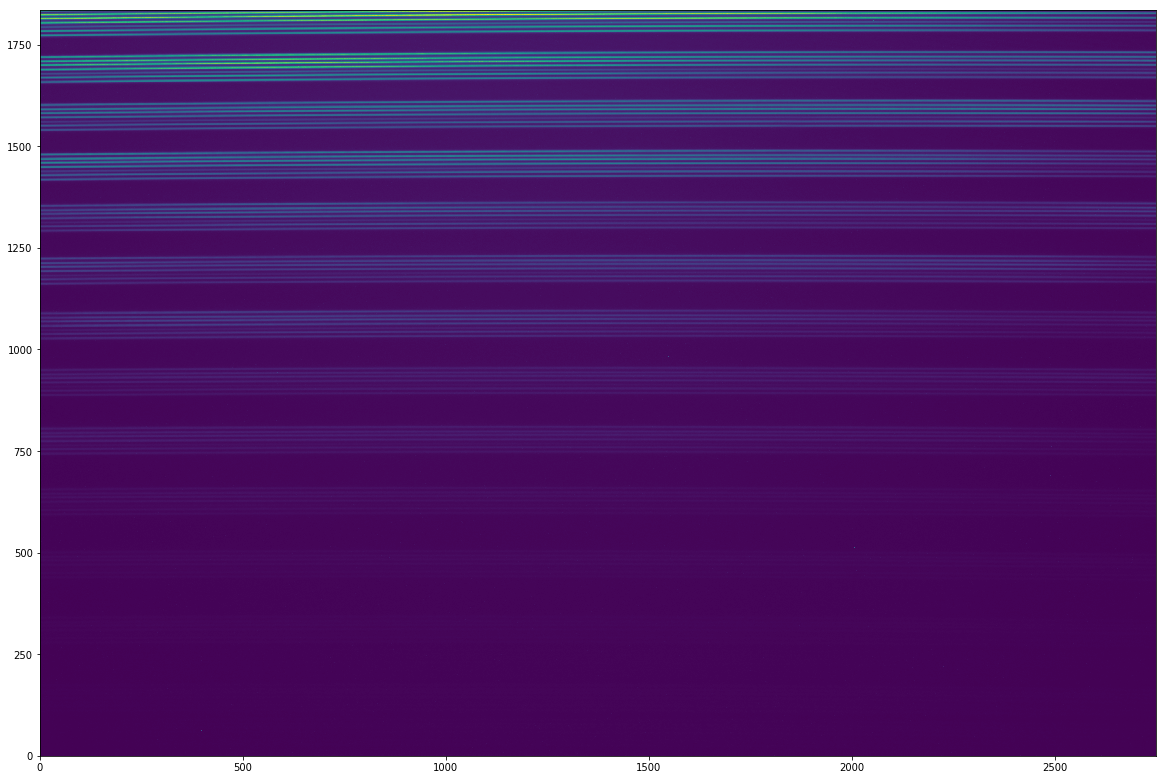

In [62]:
#flat.shape

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(procflat,origin='lower',cmap='viridis')

#procflat

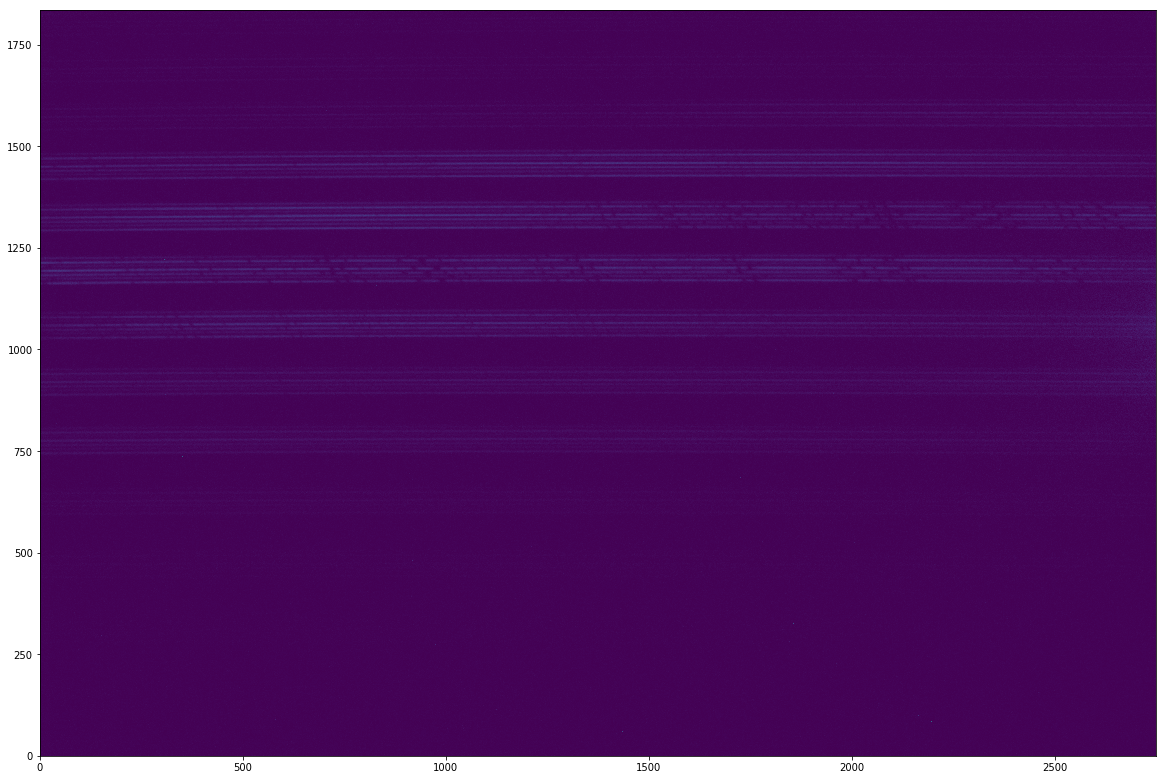

In [65]:
#flat.shape

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(procsci,origin='lower',cmap='viridis')

#print(np.median(procsci))
#print(np.min(procsci))
#print(np.max(procsci))

#procflat

### Set a box to evaluate a section of the frame

In [66]:
## pick a coordinate for the lower left coordinate of the rectangle
#xorigin=(0,250)
xorigin=(0,500)


##no need to chance these, picking a different width will slow down the animation generation
## the height will cover about 3-4 cross dispersions of the MCF
xwidth=2748
yheight=90

### II. Use the flat exposure to locate order locations

### Show the selection on the frame and mark the orders manually

[  544.   528.   520. ... 11124. 14464. 18456.]


Text(0.5,1,'Orders')

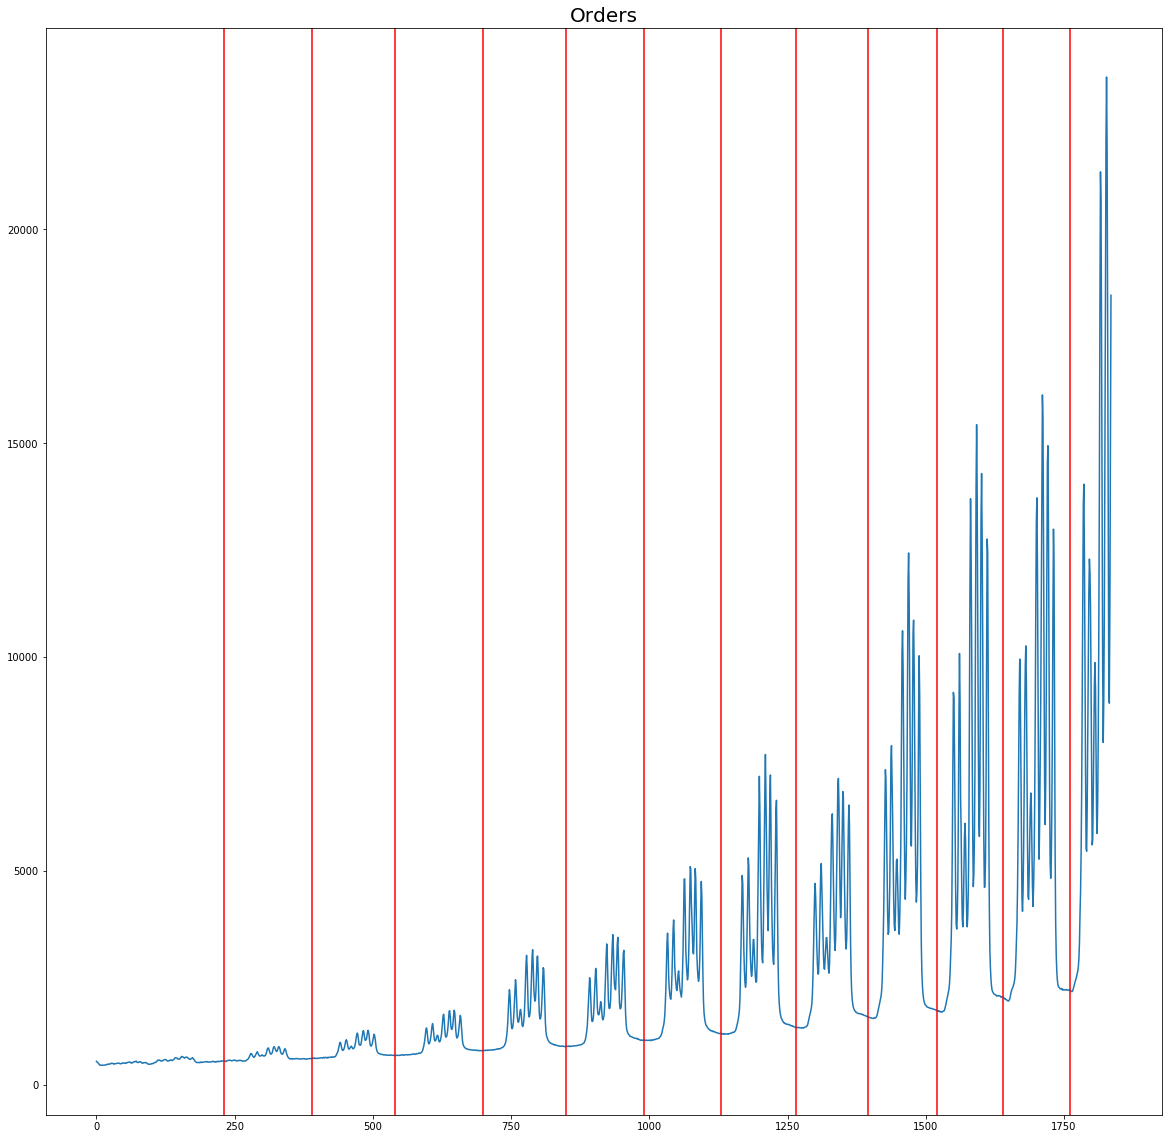

In [122]:
flat_median = np.median(procflat,axis=1)
print(flat_median)


orders=[230,390,540,700,850,990,1130,1265,1395,1520,1640,1760]

plt.figure(figsize=(20, 20))
plt.plot(np.median(procflat,axis=1))
for i in orders:
    plt.axvline(i,color='red')
plt.title("Orders",fontsize=20)

good features in order 4 and 5 
1130,1265
1265,1395

### Crop out order 4 and 5 on the processed flat, cal and science exposures

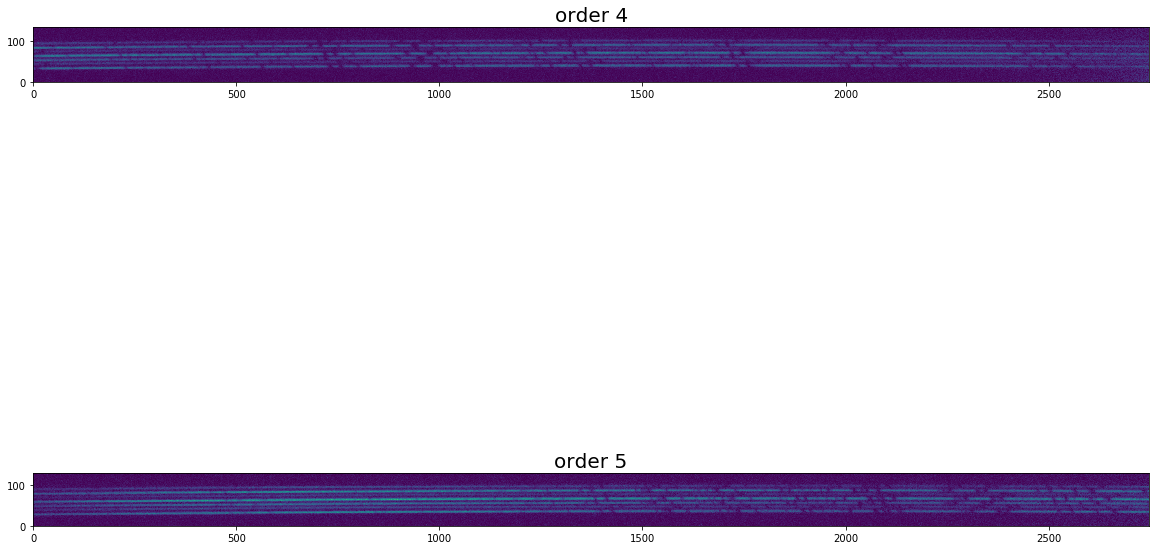

In [475]:
1650,1760


orderflat4=ccdproc.trim_image(procflat[1130:1265,:])
orderflat5=ccdproc.trim_image(procflat[1265:1395,:])

ordercal4=ccdproc.trim_image(proccal[1130:1265,:])
ordercal5=ccdproc.trim_image(proccal[1265:1395,:])


ordersci4=ccdproc.trim_image(procsci[1130:1265,:])
ordersci5=ccdproc.trim_image(procsci[1265:1395,:])

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax = plt.subplot(2,1,1)
plt.title("order 4",fontsize=20)
ax.imshow(ordersci4,origin='lower',cmap='viridis')
ax = plt.subplot(2,1,2)
plt.title("order 5",fontsize=20)
ax.imshow(ordersci5,origin='lower',cmap='viridis')

## Process Order 4

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [381]:
# manually determine bound for central core start and end pixel row
cc0 = 60
cc1 = 72

Text(0.5,1,'Plot of pixel column 100 (cross dispersion direction) of Order 4')

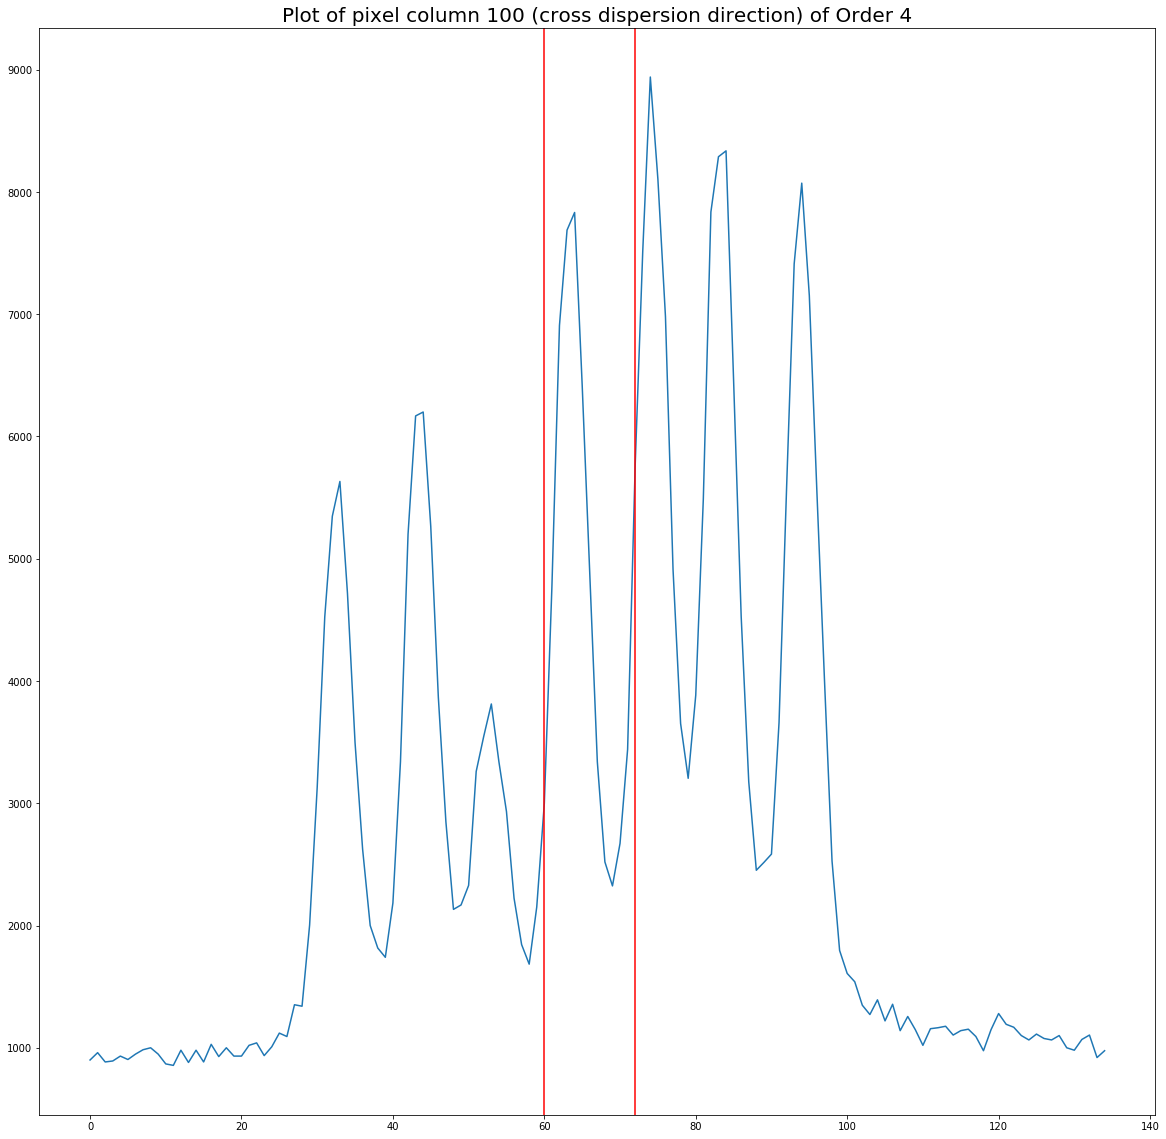

In [382]:
plt.figure(figsize=(20, 20))
#plt.scatter(np.arange(2748),column_peaks)
plt.plot(orderflat4.data[:,100])
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column 100 (cross dispersion direction) of Order 4",fontsize=20)

Plot outall the co9lumns superimposed to see if all the peaks of the central core will fit in the bound box

Text(0.5,1,'Order 4')

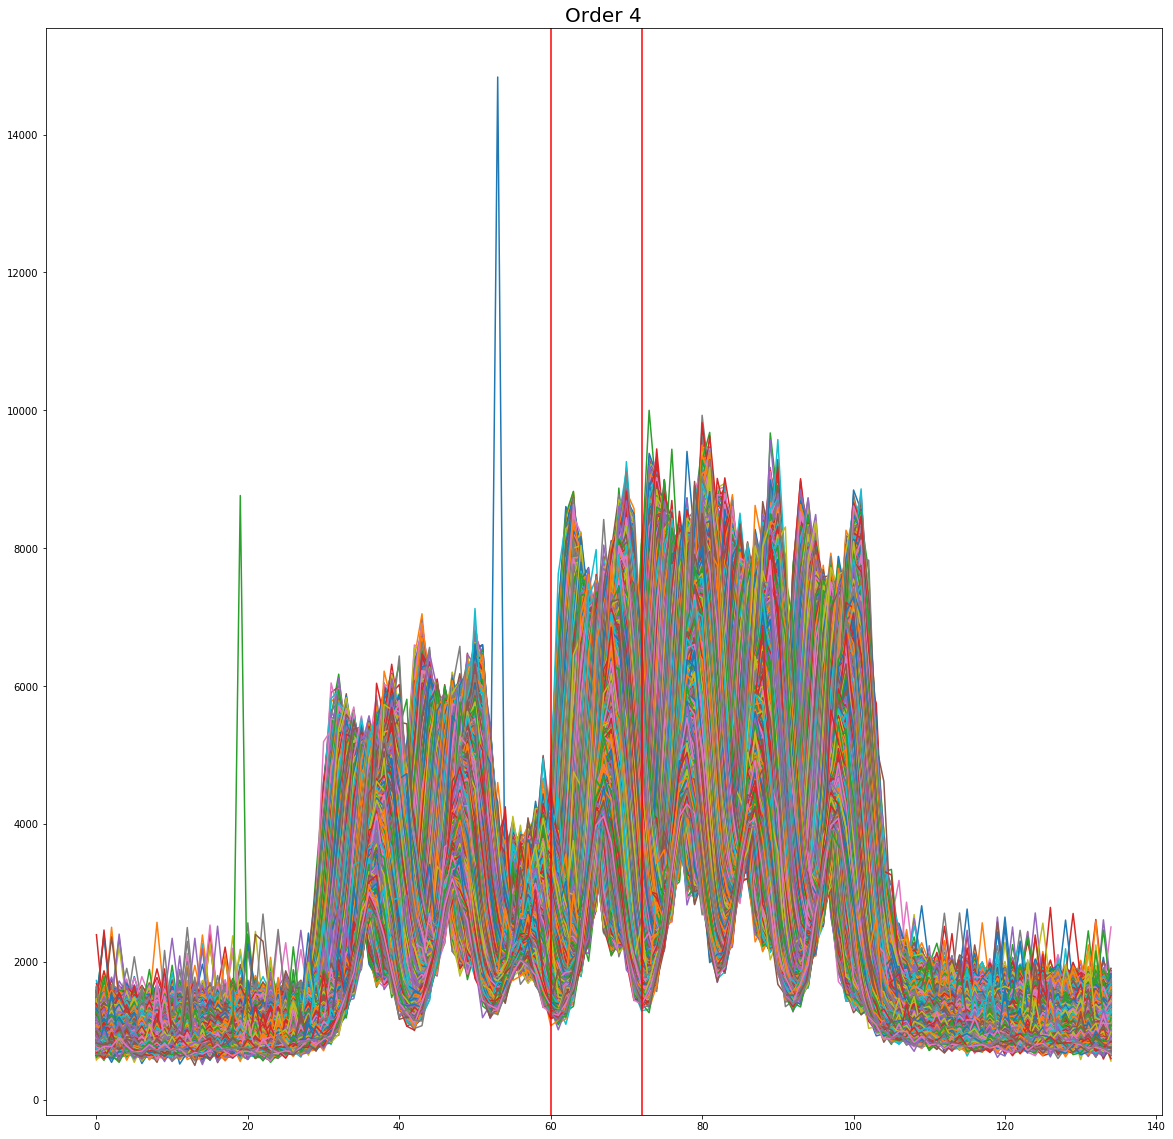

In [387]:
plt.figure(figsize=(20, 20))
#plt.scatter(np.arange(2748),column_peaks)
plt.plot(orderflat4.data[:,0:2748])
plt.axvline(cc1,color='red')
plt.axvline(cc0,color='red')
plt.title("Order 4 all columns flattened",fontsize=20)

Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [384]:
#plt.figure(figsize=(20, 15))
#plt.plot(np.median(ordersci4[:,4:10],axis=1))
#plt.title("Order 4",fontsize=20)

ordersci4.shape


column_peaks = []
column_peaks_intensity = []
which_mcf = 0

i=0
#y, _ = find_peaks(cropimg[:,0], height=200,distance=7)
for i in range(2748):
    y, _ = find_peaks(orderflat4.data[cc0:cc1,i], height=2500)
    column_peaks.append(y[which_mcf]+cc0)
    column_peaks_intensity.append(orderflat4.data[y[which_mcf]+cc0,i])
    #print(y)
    
#column_peaks.count

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=5)
column_peaks_intensity = np.array(column_peaks_intensity)

column_peaks.shape
#np.arange(2678)

#orderflat4.data[:,1]

(2748,)

Text(0.5,1,'Order 4')

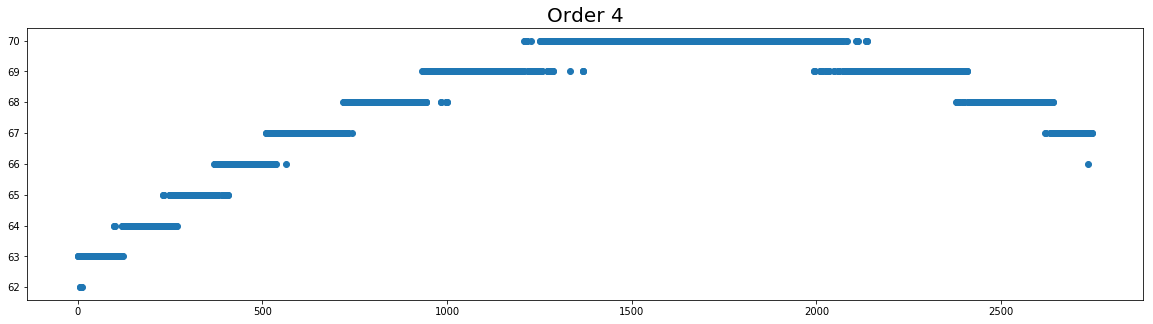

In [385]:
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(2748),column_peaks)
#plt.plot(orderflat4.data[:,1000])
#plt.axhline(82,color='red')
#plt.axhline(72,color='red')
plt.title("Order 4 center core pixel locations",fontsize=20)

### crop out just the center core of order 4

In [389]:
orderflat4cc=ccdproc.trim_image(procflat[1130+cc0:1130+cc1,:])
#orderflat5=ccdproc.trim_image(procflat[1265:1395,:])

ordercal4cc=ccdproc.trim_image(proccal[1130+cc0:1130+cc1,:])
#ordercal5=ccdproc.trim_image(proccal[1265:1395,:])


ordersci4cc=ccdproc.trim_image(procsci[1130+cc0:1130+cc1,:])
#ordersci5=ccdproc.trim_image(procsci[1265:1395,:])

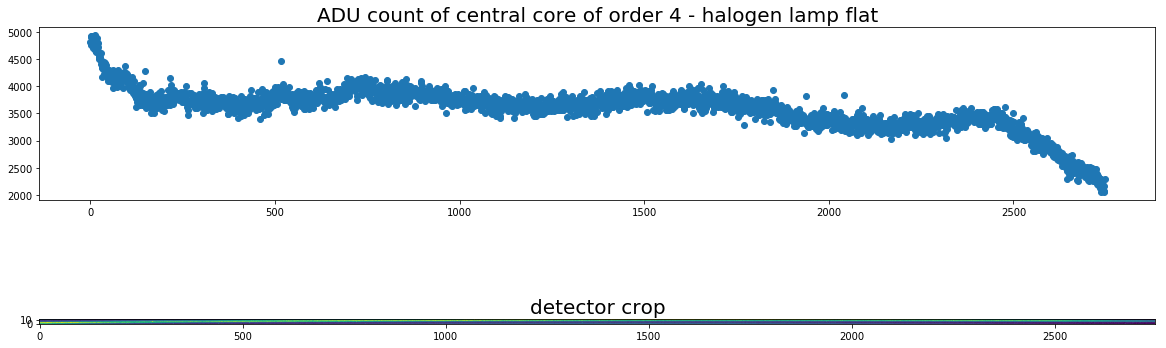

In [415]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 7)

ax = plt.subplot(2,1,1)
plt.scatter(np.arange(2748),np.median(orderflat4cc,axis=0))
plt.title("ADU count of central core of order 4 - halogen lamp flat",fontsize=20)

ax = plt.subplot(2,1,2)
plt.title("detector crop",fontsize=20)
ax.imshow(orderflat4cc,origin='lower',cmap='viridis')

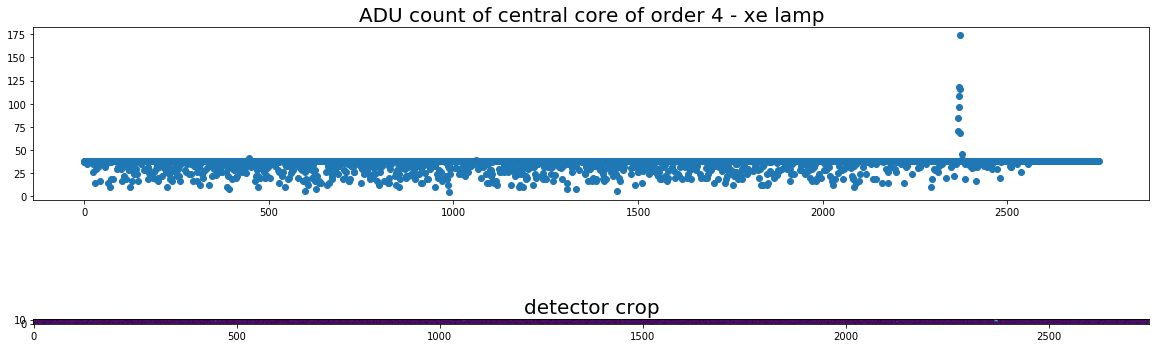

In [413]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 7)

ax = plt.subplot(2,1,1)
plt.scatter(np.arange(2748),np.median(ordercal4cc,axis=0))
plt.title("ADU count of central core of order 4 - xe lamp",fontsize=20)

ax = plt.subplot(2,1,2)
plt.title("detector crop",fontsize=20)
ax.imshow(ordercal4cc,origin='lower',cmap='viridis')

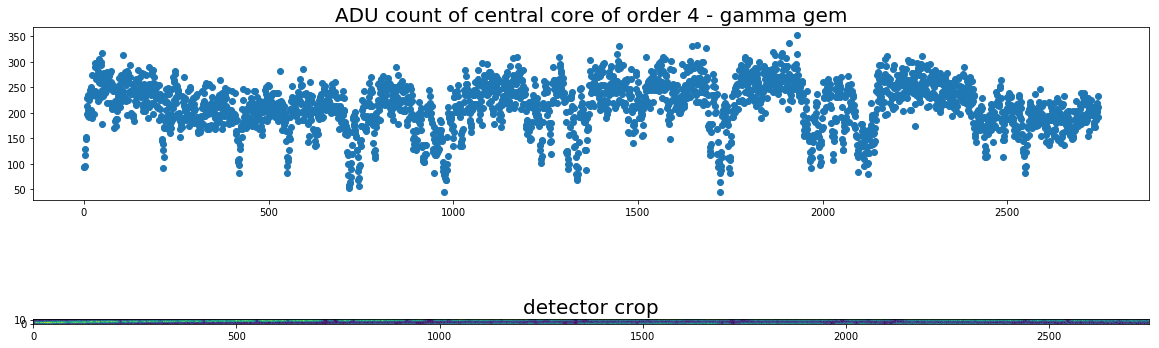

In [412]:
#plt.figure(figsize=(20, 5))

fig,ax = plt.subplots()

fig.set_size_inches(20, 7)

ax = plt.subplot(2,1,1)
plt.scatter(np.arange(2748),np.median(ordersci4cc,axis=0))
plt.title("ADU count of central core of order 4 - gamma gem",fontsize=20)

ax = plt.subplot(2,1,2)
plt.title("detector crop",fontsize=20)
ax.imshow(ordersci4cc,origin='lower',cmap='viridis')


## Process Order 5

### plot a column (along the cross dispeersion direction) to see the location of dispersions of the cores

In [438]:
# manually determine bound for central core start and end pixel row
cc0 = 56
cc1 = 67

Text(0.5,1,'Plot of pixel column 100 (cross dispersion direction) of Order 5')

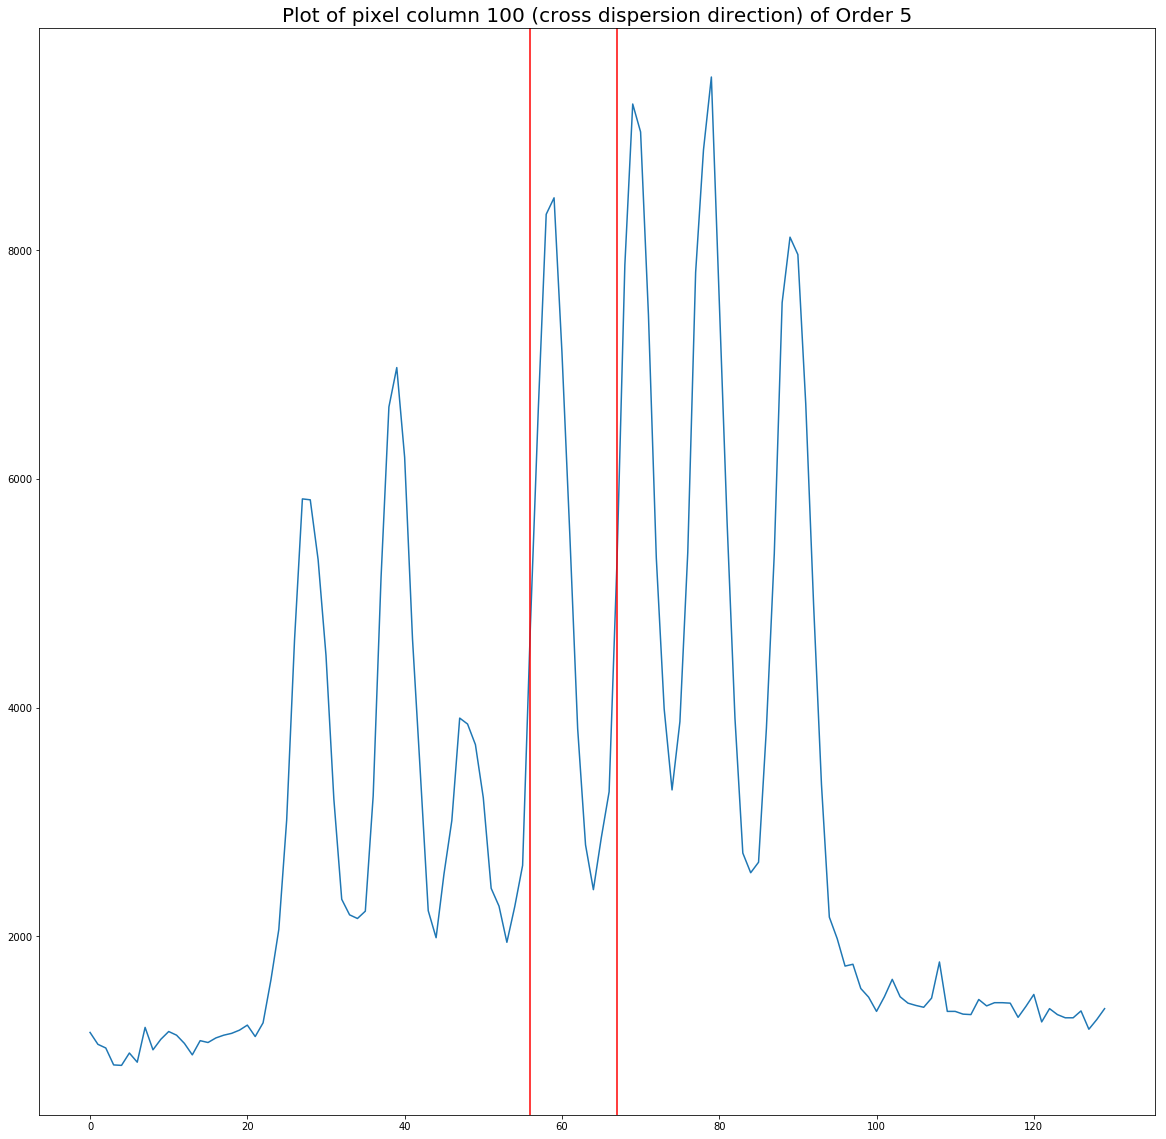

In [439]:
plt.figure(figsize=(20, 20))
#plt.scatter(np.arange(2748),column_peaks)
plt.plot(orderflat5.data[:,100])
plt.axvline(cc0,color='red')
plt.axvline(cc1,color='red')
plt.title("Plot of pixel column 100 (cross dispersion direction) of Order 5",fontsize=20)

Plot out all the columns superimposed to see if all the peaks of the central core will fit in the bound box

Text(0.5,1,'Order 5 all columns flattened')

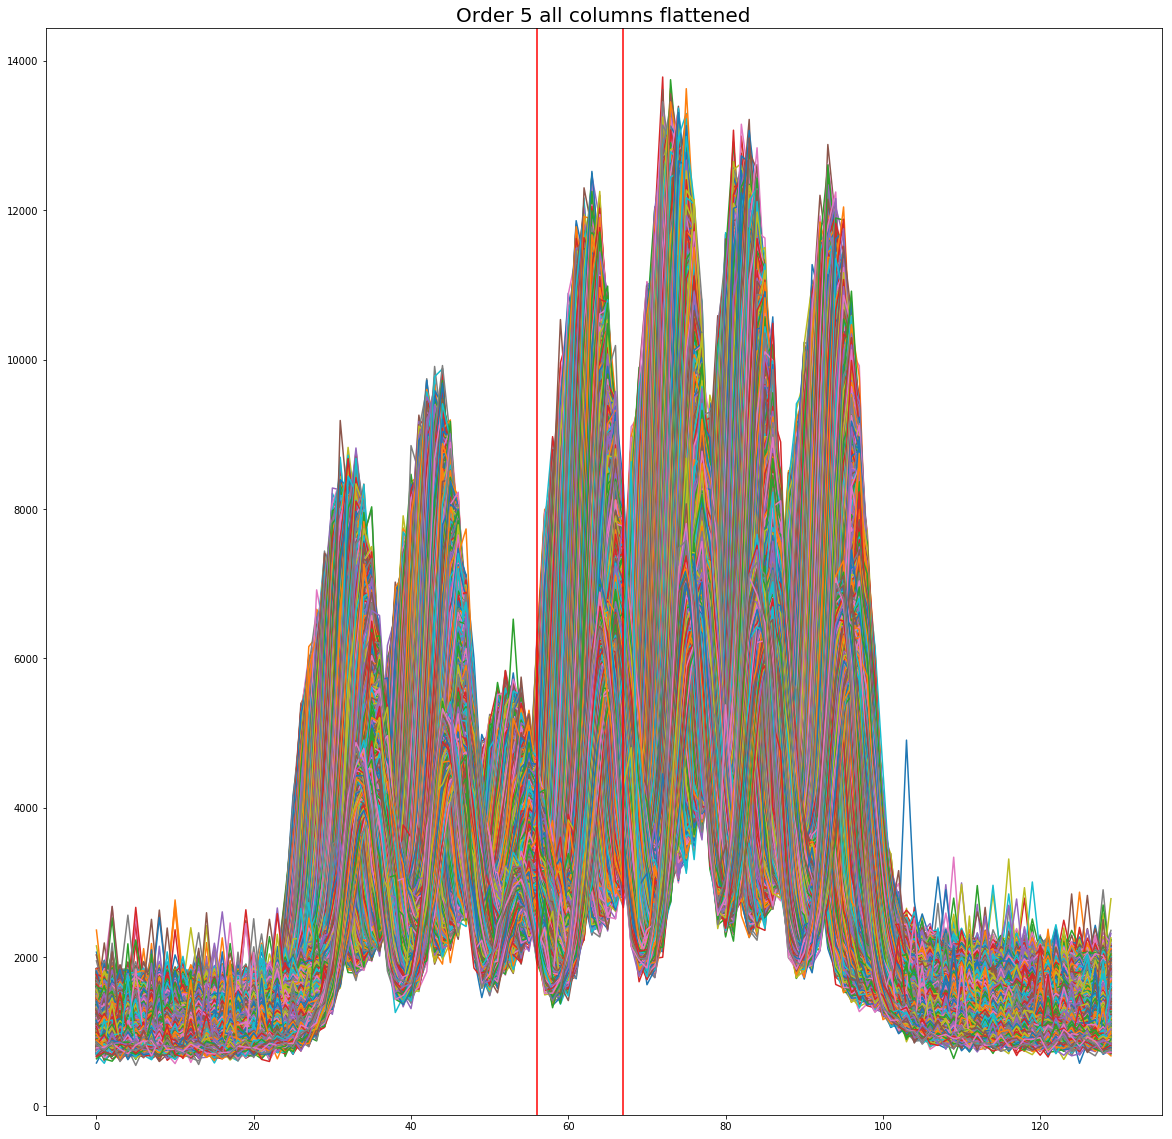

In [468]:
plt.figure(figsize=(20, 20))
#plt.scatter(np.arange(2748),column_peaks)
plt.plot(orderflat5.data[:,0:2748])
plt.axvline(cc1,color='red')
plt.axvline(cc0,color='red')
plt.title("Order 5 all columns flattened",fontsize=20)

Determine the peak in the bound specified and store the value, use a median filter to smooth out outliers

In [466]:
#plt.figure(figsize=(20, 15))
#plt.plot(np.median(ordersci4[:,4:10],axis=1))
#plt.title("Order 4",fontsize=20)


column_peaks = []
column_peaks_intensity = []
which_mcf = 0

i=0
#y, _ = find_peaks(cropimg[:,0], height=200,distance=7)
for i in range(2748):
    y, _ = find_peaks(orderflat5.data[cc0:cc1,i], height=2000)
    if y.shape[0] == 0:
        tenwindow=len(column_peaks)-10
        tenwindowend=len(column_peaks)
        #print(tenwindow)
        #print(tenwindowend)
        fake_peak = int(np.median(column_peaks[tenwindow:tenwindowend]))
        #print(fake_peak)
        column_peaks.append(fake_peak)
        column_peaks_intensity.append(orderflat5.data[fake_peak,i])
    else:
        column_peaks.append(y[which_mcf]+cc0)
        column_peaks_intensity.append(orderflat5.data[y[which_mcf]+cc0,i])
    #print(y)
    
#column_peaks.count

column_peaks = np.array(column_peaks)
column_peaks = medfilt(column_peaks,kernel_size=9)
column_peaks_intensity = np.array(column_peaks_intensity)

#column_peaks.shape
#np.arange(2678)

Text(0.5,1,'Order 5 center core pixel locations')

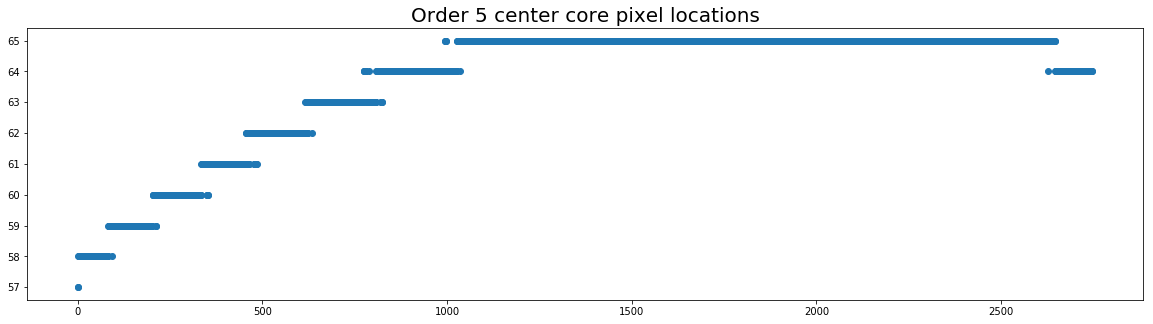

In [471]:
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(2748),column_peaks)
#plt.plot(orderflat5.data[:,1000])
#plt.axhline(82,color='red')
#plt.axhline(72,color='red')
plt.title("Order 5 center core pixel locations",fontsize=20)

### crop out just the center core of order 5

In [476]:
#orderflat4cc=ccdproc.trim_image(procflat[1130+cc0:1130+cc1,:])
orderflat5cc=ccdproc.trim_image(procflat[1265+cc0:1265+cc1,:])

#ordercal4cc=ccdproc.trim_image(proccal[1130+cc0:1130+cc1,:])
ordercal5cc=ccdproc.trim_image(proccal[1265+cc0:1265+cc1,:])


#ordersci4cc=ccdproc.trim_image(procsci[1130+cc0:1130+cc1,:])
ordersci5cc=ccdproc.trim_image(procsci[1265+cc0:1265+cc1,:])

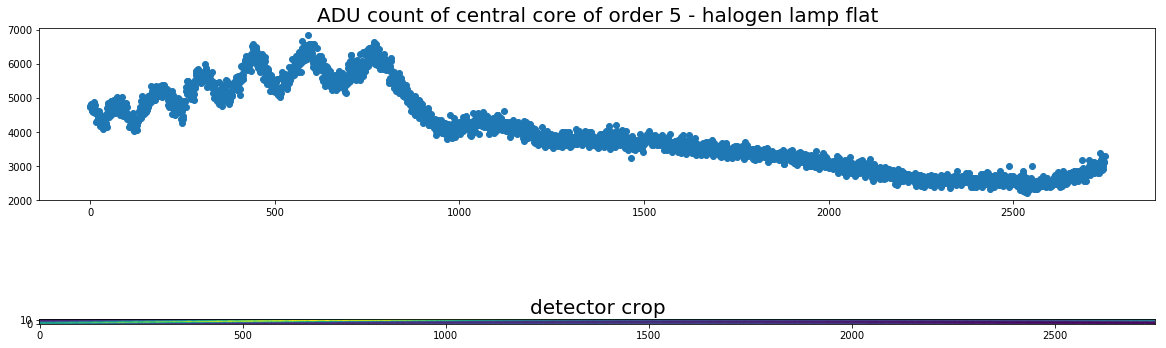

In [479]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 7)

ax = plt.subplot(2,1,1)
plt.scatter(np.arange(2748),np.median(orderflat5cc,axis=0))
plt.title("ADU count of central core of order 5 - halogen lamp flat",fontsize=20)

ax = plt.subplot(2,1,2)
plt.title("detector crop",fontsize=20)
ax.imshow(orderflat5cc,origin='lower',cmap='viridis')

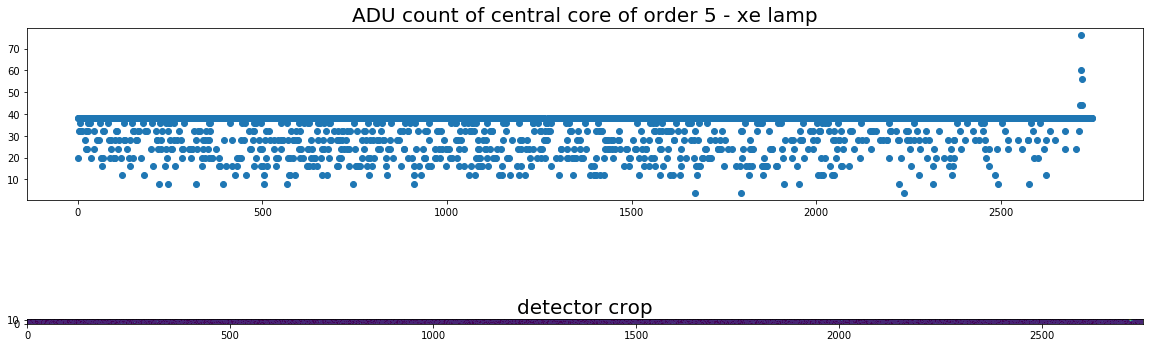

In [480]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 7)

ax = plt.subplot(2,1,1)
plt.scatter(np.arange(2748),np.median(ordercal5cc,axis=0))
plt.title("ADU count of central core of order 5 - xe lamp",fontsize=20)

ax = plt.subplot(2,1,2)
plt.title("detector crop",fontsize=20)
ax.imshow(ordercal5cc,origin='lower',cmap='viridis')

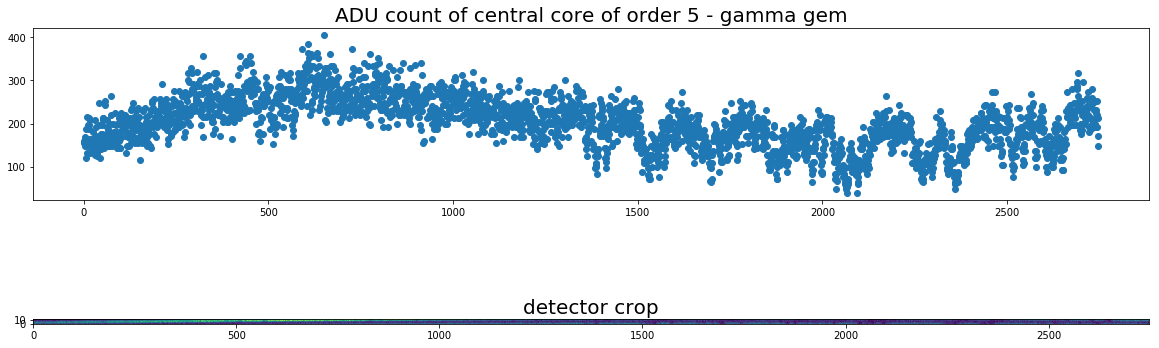

In [481]:
#plt.figure(figsize=(20, 5))

fig,ax = plt.subplots()

fig.set_size_inches(20, 7)

ax = plt.subplot(2,1,1)
plt.scatter(np.arange(2748),np.median(ordersci5cc,axis=0))
plt.title("ADU count of central core of order 5 - gamma gem",fontsize=20)

ax = plt.subplot(2,1,2)
plt.title("detector crop",fontsize=20)
ax.imshow(ordersci5cc,origin='lower',cmap='viridis')
